

### 1. Import the Necessary Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import numpy as np
import random
import copy
import gym
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cpu')

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
action_size = env.action_space.n
action_size

4

In [4]:
state_low = env.observation_space.low
state_high = env.observation_space.high
state_size = len(state_low)
state_low, state_high, state_size

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf], dtype=float32),
 8)

### 3. Define hyperparameters

These are **really** important, because small change in the parameter values can really 
affect the training time and efficency. 
My training was really affected by learning rate and number of nodes in the hidden layer. 
I first set up my LR = 0.01, - it trained fine at first but used to decline after the avg. 
rewards reach 150. So, I set up my LR = 0.0005 and it trained faster and efficently.

Also, do not complicate the network. Increasing number of hidden layers and nodes surely
might increase your training efficeny, but also take care of the time it will take to train.
So, start with a simpler model with small number of hidden layer with small number of 
hidden nodes - it might just work for your need

In [5]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 1.0
UPDATE_EVERY = 4
TAU = 1e-3
LR = 5e-4

### 4. Define Model

Initialize the model - take care that I have not added an activation function in the output
layer of the network, because we will use that to calculate our Q values in the end for 
our loss function.

In [6]:
class Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Model, self).__init__()
        self.seed = torch.manual_seed(42)
        
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        
        action_values = self.fc3(state)
        
        return action_values

### 5. Instantiate ReplayBuffer

A reply memory to sample the previous experiences taken out in random to learn and train 
our neural network.

In [7]:
class ReplayBuffer:
    def __init__(self, buffer_size, action_size):
        self.seed = random.seed(42)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experiences", field_names=["state","action","reward","new_state", "done"])
        
    def add(self, state, action, reward, new_state, done):
        e = self.experiences(state, action, reward, new_state, done)
        self.memory.append(e)
        
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, new_states, dones
    
    def __len__(self):
        return len(self.memory)

### 6. Initialize the Agent


In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        self.seed = random.seed(42)
        self.action_size = action_size
        
        self.local_nn = Model(state_size, action_size).to(device)
        self.target_nn = Model(state_size, action_size).to(device)
        
        self.optimizer = optim.Adam(self.local_nn.parameters(), lr=LR)
        
        self.memory = ReplayBuffer(BUFFER_SIZE, action_size)
        
        self.t_step = 0
        
        
    def step(self, state, action, reward, new_state, done):
        self.memory.add(state, action, reward, new_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_nn.eval()
        with torch.no_grad():
            action_values = self.local_nn(state)
        self.local_nn.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, new_states, dones = experiences
        
        Q_target = self.target_nn(new_states).detach().max(1)[0].unsqueeze(1)
        Q_target_value = rewards + (gamma * Q_target * (1-dones))
        
        Q_exp = self.local_nn(states).gather(1, actions)
        loss = F.mse_loss(Q_exp, Q_target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.local_nn, self.target_nn, TAU)
        
    def soft_update(self, local_nn, target_nn, tau):
        for local_nn_params, target_nn_params in zip(local_nn.parameters(), target_nn.parameters()):
            target_nn_params.data.copy_(tau*local_nn_params.data + (1.0-tau)*target_nn_params.data)

In [9]:
agent = DQNAgent(state_size, action_size)

### 7. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  


In [10]:
def dqn():
    n_episodes = 5000
    score_deque = deque(maxlen=100)
    scores = []
    eps = 1.0
    decay = 0.995
    min_eps = 0.005
    
    for i_episode in range(n_episodes):
        state = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.act(state, eps)
            new_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, new_state, done)
            state = new_state
            score += reward
            if done:
                break
                
        score_deque.append(score)
        scores.append(score)
        
        eps = max(min_eps, eps*decay)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_deque)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_deque)))
        if np.mean(score_deque)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(score_deque)))
            torch.save(agent.local_nn.state_dict(), 'checkpoint.pth')
            break
    return scores

In [11]:
scores = dqn()

Episode 0	Average Score: -43.08
Episode 100	Average Score: -178.39
Episode 200	Average Score: -96.775
Episode 300	Average Score: -45.08
Episode 400	Average Score: 45.365
Episode 500	Average Score: 77.34
Episode 596	Average Score: 202.19
Environment solved in 496 episodes!	Average Score: 202.19


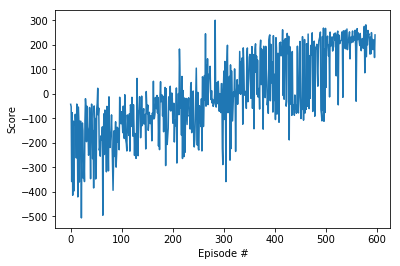

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Watch a Smart Agent

Load the saved model weights from a pre-trained agent.

In [13]:
state = env.reset()
done = False
score = 0 
agent.local_nn.load_state_dict(torch.load('checkpoint.pth'))
# agent.local_nn.eval(
while not done:
    env.render()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print(score)
        break
    

229.68390301746336


In [14]:
env.close()